## Import libraries

In [2]:
import os
import random

import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
sns.set(font_scale=2.5) 

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
#Random seed
np.random.seed(7)
random.seed(7)
random_state=7

## Data scan

In [4]:
train = pd.read_csv('./datasets/train.csv')
test  = pd.read_csv('./datasets/test.csv')
submission = pd.read_csv('./datasets/submission.csv')

In [4]:
train.head()

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2


In [5]:
train.describe()

,id,digit,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
count,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,...,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000
mean,1024.500000,4.440918,2.031250,1.959961,1.971680,2.018066,1.988770,1.959473,2.041504,1.994629,...,2.034180,1.978516,1.972656,2.010742,1.958008,2.043457,2.035156,1.981445,1.993164,1.975586
std,591.350996,2.819159,1.420762,1.399057,1.415311,1.415307,1.419169,1.421730,1.420671,1.419548,...,1.420694,1.390359,1.407022,1.443575,1.415662,1.407484,1.399886,1.409247,1.392264,1.398719
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,512.750000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1024.500000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,1536.250000,7.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,2048.000000,9.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [6]:
test.head()

,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,...,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,...,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,...,4,3,1,4,0,2,1,2,3,4


In [7]:
test.describe()

,id,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
count,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,...,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000
mean,12288.500000,1.999561,2.010742,1.998877,2.002344,1.998584,1.985742,2.007520,2.008154,2.001123,...,1.977832,1.999902,2.000732,1.980078,2.009717,2.005518,2.000342,2.009717,1.990576,1.988965
std,5912.211092,1.409389,1.421062,1.413989,1.410131,1.413021,1.416040,1.418538,1.417139,1.416852,...,1.413764,1.414075,1.410601,1.418865,1.415405,1.419459,1.412642,1.412124,1.408491,1.420235
min,2049.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7168.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,12288.500000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,17408.250000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,22528.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


- 주어진 data는 28x28 (784개 픽셀) 이미지이다.
- 전체 데이터 22528개 중 2048개는 Training data, 20480개는 Test data로 주어졌다.
- 픽셀값 중 max가 4인 것은 노이즈로 보이므로 처리해 줄 필요가 있어보인다.
- 자세히 확인해보면 픽셀값의 범위는 0~255이다.
- 학습 데이터가 적기 때문에 semi-supervised learning과 data augmentation이 중요해 보인다.

## Null data check

In [8]:
train.isnull().any().describe()

count       787
unique        1
top       False
freq        787
dtype: object

In [9]:
test.isnull().any().describe()

count       786
unique        1
top       False
freq        786
dtype: object

- 확인결과 Null data 없음

## 데이터 샘플 확인하기

### 1. Train data

In [10]:
# 학습데이터중 28번째 행에 있는 A라는 글자를 확인해 보자
img = train.query("letter == 'A'")[[(str(i)) for i in range(784)]].iloc[28].values.reshape(28, 28)

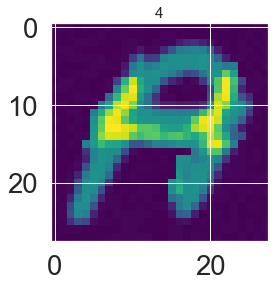

In [11]:
img = train.query("letter == 'A'")[[(str(i)) for i in range(784)]].iloc[28].values.reshape(28, 28)
plt.imshow(img, cmap='viridis')
plt.title(train.query("letter == 'A'").iloc[28]['digit'], fontsize=15)
plt.show()

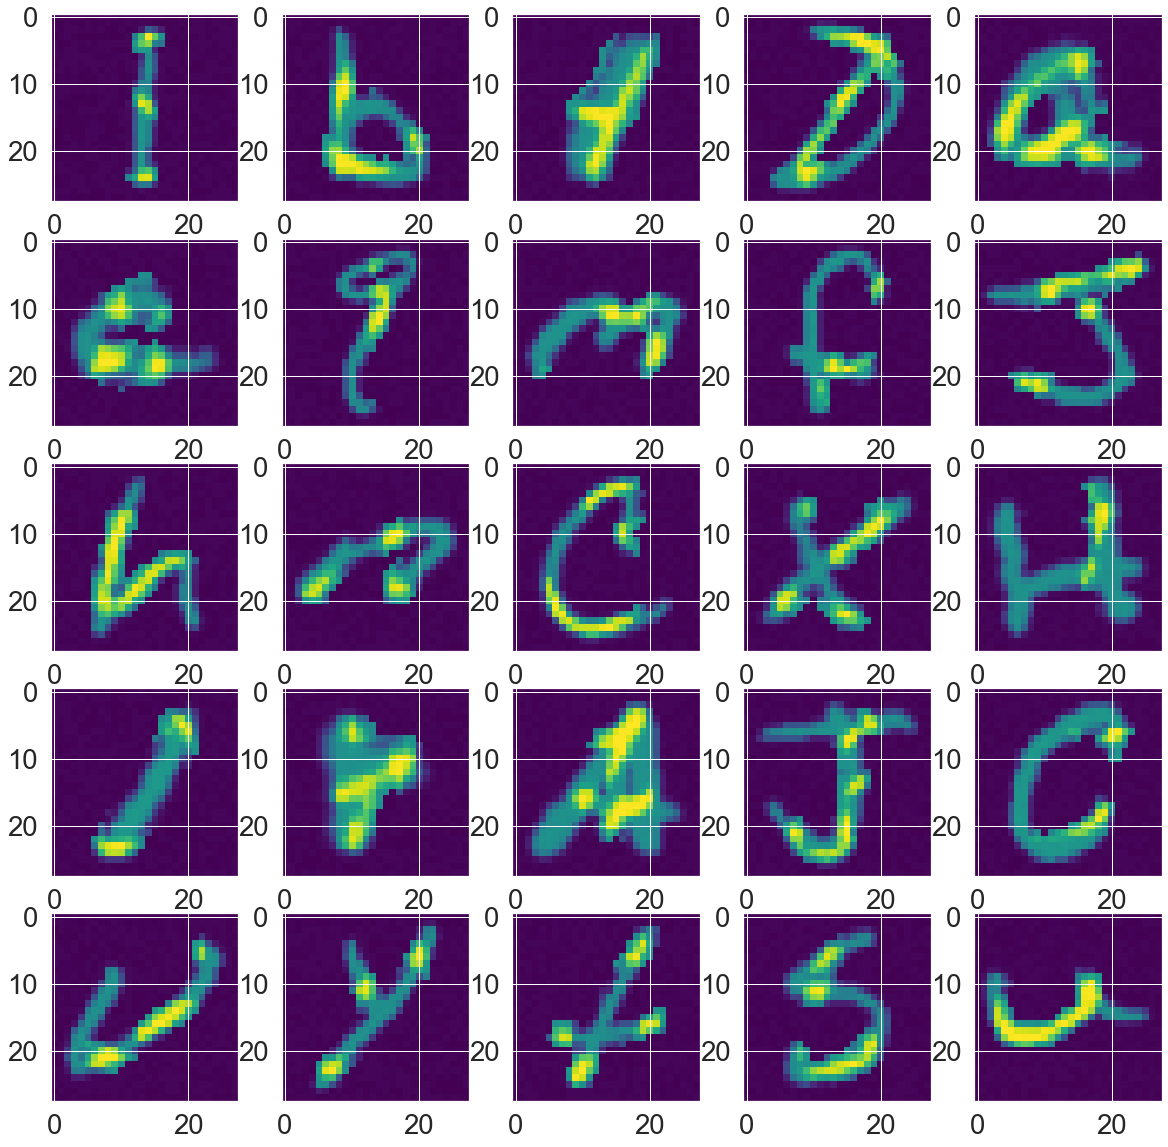

In [12]:
# multi-img show
imgs = []

plt.figure(figsize=(20,20))

for i in range(25):
    img = train.iloc[i,3:].values.reshape(28, 28)
    imgs.append(img)

# list 자료형으로는 img를 나타낼 수 없으므로 numpy 자료형으로 바꾸어 준다.    
# 데이터 타입 에러 발생으로 np.float32를 추가해준다
imgs = np.array(imgs)
imgs = imgs.astype(np.float32)

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(imgs[i, :, :], cmap='viridis')

plt.subplot(5,5,25)
plt.show()

- 데이터에 대문자와 소문자가 섞여 있다.
- 데이터에 알아보기 힘든 숫자도 존재한다. (알고리즘은 숫자의 둥근 형태나 직선 형태의 부분부분을 학습할 듯하다.)
- target value(digit)은 영어 글자와 숫자가 겹치는 부분만 특징적으로 노란색으로 나타나게 조작되었다.
- digit만 처리해서 학습시킬지 letter도 같이 학습시킬지 다양한 실험이 필요하다

### 2. Test data

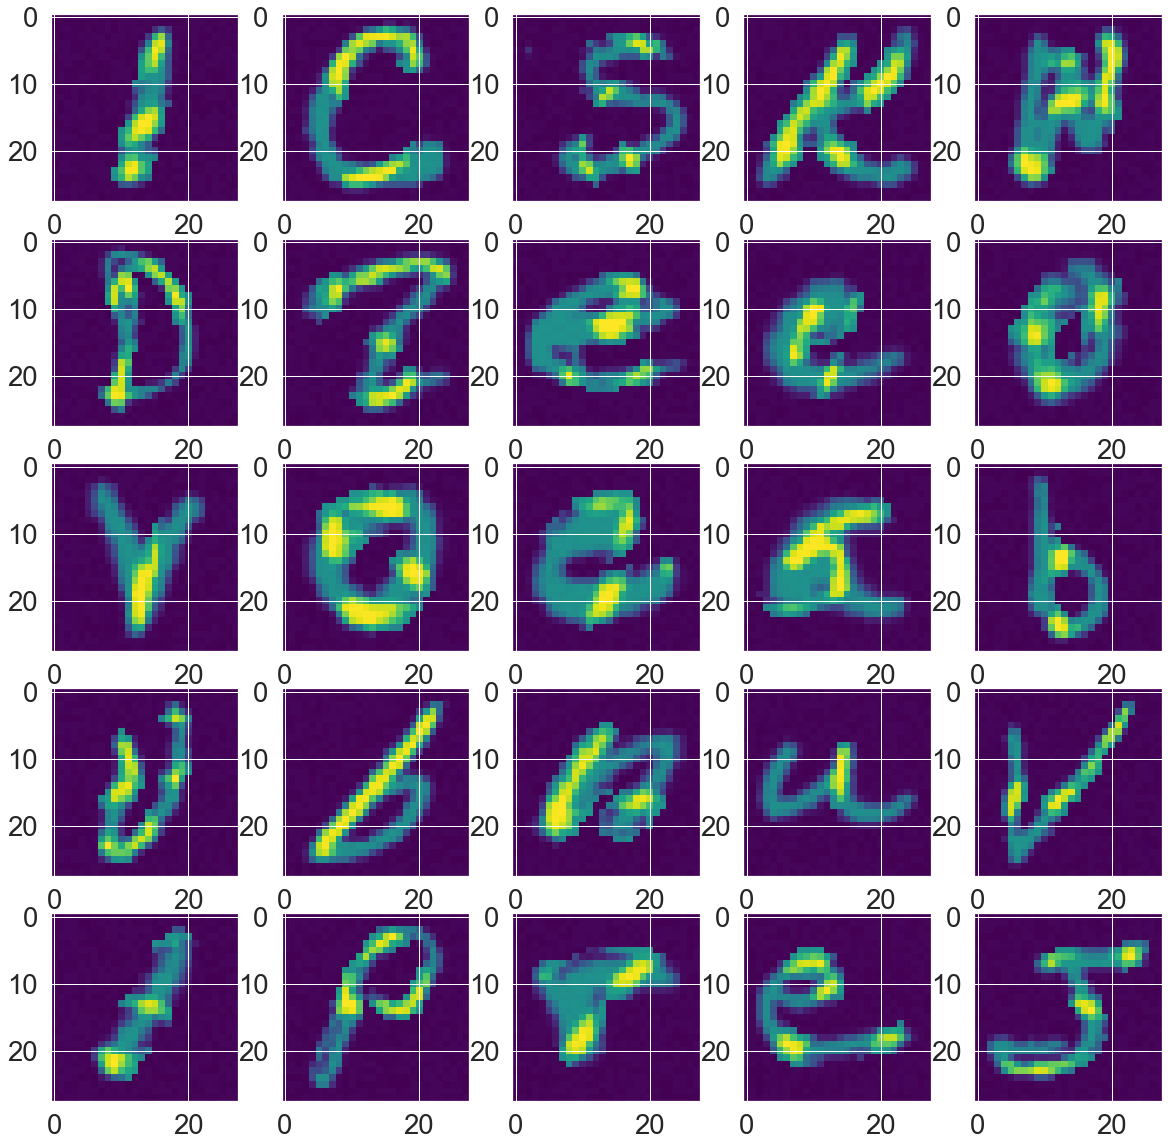

In [13]:
# 테스트 데이터 여러 개를 확인해 본다.

imgs = []

plt.figure(figsize=(20,20))

for i in range(25):
    img = test.iloc[i,2:].values.reshape(28, 28)
    imgs.append(img)

imgs = np.array(imgs)
imgs = imgs.astype(np.float32)

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(imgs[i, :, :], cmap='viridis')

plt.subplot(5,5,25)
plt.show()

## 데이터 통계분석

### 1. Train data

In [14]:
train_digit = train['digit']
train_digit.value_counts().sort_values()

# index 순서대로 정렬
# train_digit.value_counts().sort_index(ascending=True)

8    182
0    191
7    194
9    197
1    202
3    205
4    207
6    212
5    225
2    233
Name: digit, dtype: int64

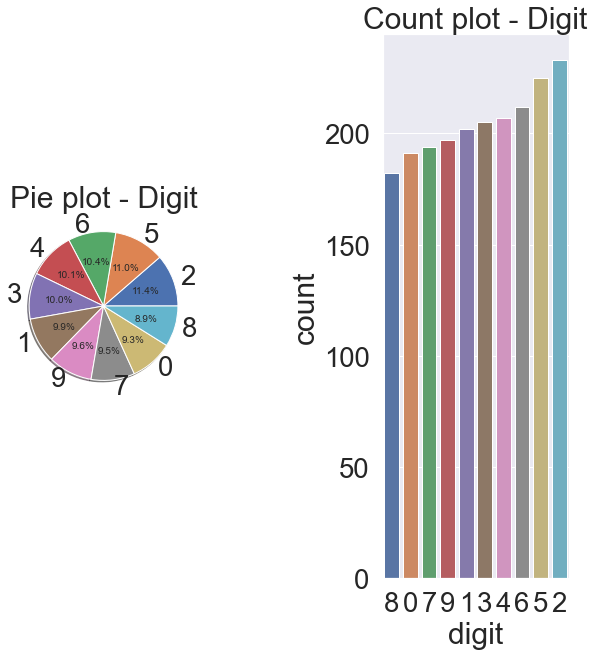

In [15]:
f, ax = plt.subplots(1, 2, figsize=(10,10))

train['digit'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Digit')
ax[0].set_ylabel('')

sns.countplot('digit', data=train, ax=ax[1], order=train['digit'].value_counts().sort_values().index)
ax[1].set_title('Count plot - Digit')

plt.subplots_adjust(wspace=1)
plt.show()

In [16]:
train_letter = train['letter']
train_letter.value_counts().sort_values()

# index 순서대로 정렬
# train_letter.value_counts().sort_index(ascending=True)

I    64
E    66
P    66
J    67
W    69
B    71
A    72
V    73
C    74
D    76
S    76
N    77
X    79
F    80
R    81
Q    82
T    82
U    85
M    86
Y    86
G    87
L    89
H    89
K    90
O    90
Z    91
Name: letter, dtype: int64

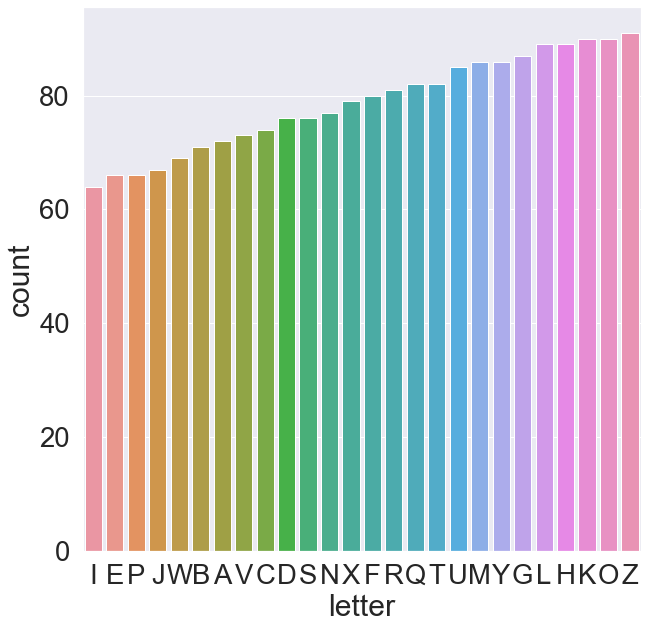

In [17]:
f, ax = plt.subplots(1, 1, figsize=(10, 10)) # 한개 플롯을 그릴때도 이렇게 subplots를 쓸 수 있다.
#sns.countplot(x='letter', data=train, order=train['letter'].value_counts().index) (내림차순으로 그리는 방법)
sns.countplot(x='letter', data=train, order=train['letter'].value_counts().sort_values().index)
plt.show()

- 분포가 일정하지 않지만 대체적으로 균일한 편이다
- sort_index() 인덱스 기준으로 정렬,  sort_values()  값 데이터 기준으로 정렬

### Test data

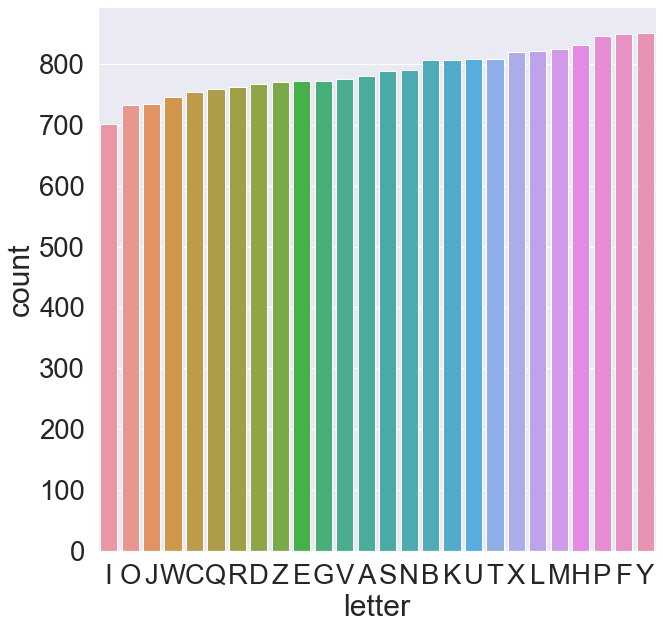

In [18]:
f, ax = plt.subplots(1, 1, figsize=(10, 10)) 
sns.countplot(x='letter', data=test, order=test['letter'].value_counts().sort_values().index)
plt.show()

## 데이터 전처리해서 확인해 보기

### 1. 픽셀값 중 '4'를 가진 픽셀 삭제

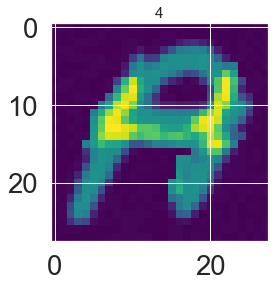

In [19]:
# 픽셀 삭제하지 않은 원형 데이터 'A', digit 4

img = train.query("letter == 'A'")[[(str(i)) for i in range(784)]].iloc[28].values.reshape(28, 28)
plt.imshow(img, cmap='viridis')
plt.title(train.query("letter == 'A'").iloc[28]['digit'], fontsize=15)
plt.show()

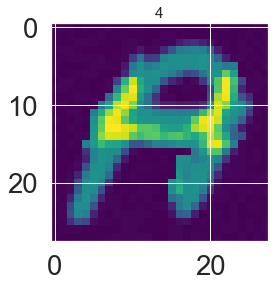

In [20]:
# 픽셀값 중 4를 차지하는 부분 삭제
new_img = np.where(img < 5, 0, img)
plt.imshow(img, cmap='viridis')
plt.title(train.query("letter == 'A'").iloc[28]['digit'], fontsize=15)
plt.show()

In [21]:
new_img

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  17,  28,  35,  23,  13,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  17,   5,
          5,  29,  66, 104, 110, 114, 112,  81,  21,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  45,  95,  44,
         47, 111, 127, 127, 127, 127, 129, 123,  81,  22,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  17, 104, 128, 104,
        113, 131, 127, 127, 123, 123, 130, 127, 124, 105, 105,   0,   0,
          0,   0],
       [  

- 노이즈라고 생각되는 부분을 삭제했는데 시각적으로 차이점은 없다

### 2. 픽셀값 중 150이하 삭제

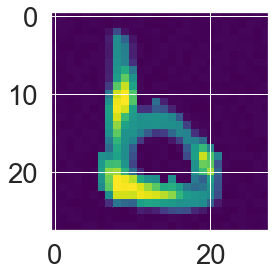

In [22]:
img = train.query("letter == 'B'")[[(str(i)) for i in range(784)]].iloc[0].values.reshape(28, 28)
#new_img = np.where(img < 5, 0, img)# 4이하의 노이즈 삭제


plt.imshow(img, cmap='viridis')
plt.show()

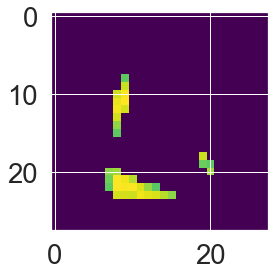

In [31]:
img = train.query("letter == 'B'")[[(str(i)) for i in range(784)]].iloc[0].values.reshape(28, 28)
#new_img = np.where(img < 5, 0, img)# 4이하의 노이즈 삭제


s_img = np.where(img >= 190, img, 0)
plt.imshow(s_img, cmap='viridis')
plt.show()


# s_img = np.where(img < 190, 0, new_img)# 4이하의 노이즈 삭제
# plt.imshow(s_img, cmap='gray')
# plt.show()

- 150이하로 두고 설정했을 때 segmentation이 나쁘지 않다. 하지만 여러값들을 실험으로 해보거나 다른 기법을 활용해 볼 필요가 있을 듯하다.

## 학습데이터 중 digit '5'를 이용하여 새로운 data feature 탐색

In [5]:
digit_5 = train.query("letter == 'A'")
digit_5.head(10)

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2
17,18,7,A,2,3,0,4,0,0,1,...,1,2,0,0,1,0,2,2,1,4
44,45,5,A,2,0,4,2,3,1,3,...,3,1,2,0,4,2,3,4,1,1
75,76,7,A,1,0,4,1,4,1,1,...,0,4,0,4,3,2,4,1,2,2
105,106,2,A,4,2,4,1,0,4,3,...,0,2,0,2,4,3,2,3,0,1
108,109,8,A,1,4,1,4,4,0,3,...,3,2,4,4,3,0,2,3,1,0
150,151,0,A,1,4,4,4,1,0,0,...,0,4,0,2,2,0,2,4,3,4
198,199,7,A,1,3,2,1,3,4,2,...,2,1,1,0,0,0,4,3,1,0
227,228,2,A,3,4,0,0,4,0,1,...,4,1,1,0,2,3,2,3,1,4
237,238,6,A,0,0,3,4,4,1,4,...,3,1,4,3,2,2,3,2,0,3


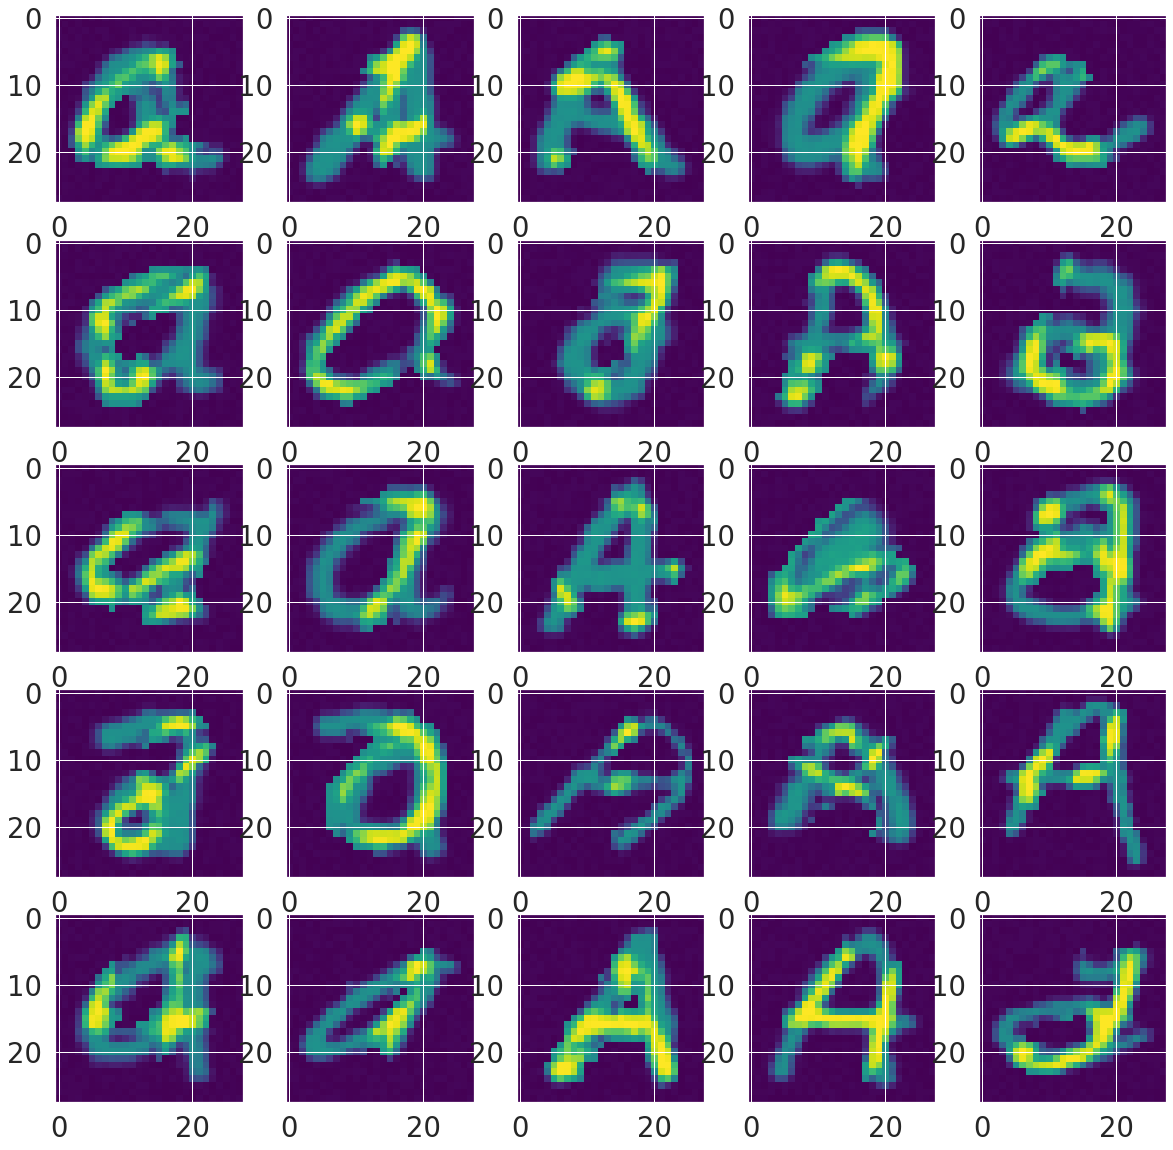

In [7]:
imgs = []

plt.figure(figsize=(20,20))

for i in range(25):
    img = digit_5.iloc[i,3:].values.reshape(28, 28)
    imgs.append(img)


imgs = np.array(imgs)
imgs = imgs.astype(np.float32)

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(imgs[i, :, :], cmap='viridis')

plt.subplot(5,5,25)
plt.show()

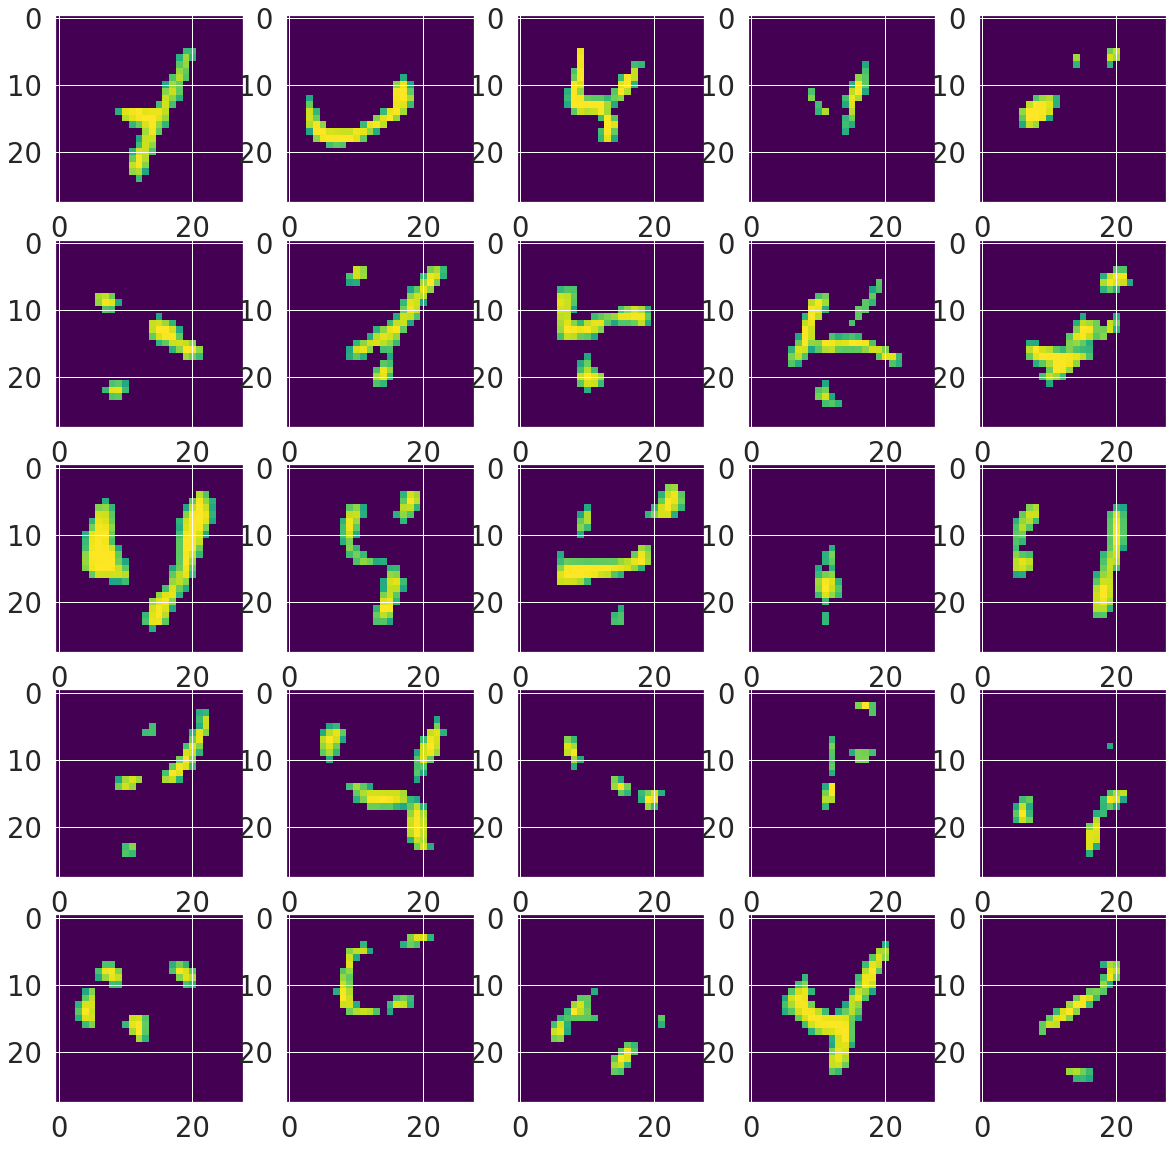

In [44]:
imgs = []

plt.figure(figsize=(20,20))

for i in range(25):
    img = digit_5.iloc[i,3:].values.reshape(28, 28)
    s_img = np.where(img >= 150, img, 0)
    imgs.append(s_img)

imgs = np.array(imgs)
imgs = imgs.astype(np.float32)

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(imgs[i, :, :], cmap='viridis')

plt.subplot(5,5,25)
plt.show()

## 숫자 5의 부분 Feature를 합쳐서 확인해보기

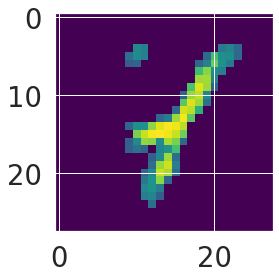

In [45]:
new = imgs[0, :, :] + imgs[6,:, :]
plt.imshow(new, cmap='viridis')
plt.show()

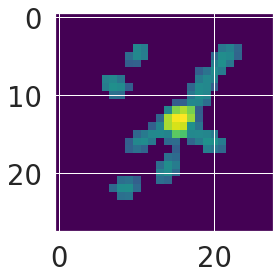

In [46]:


new = imgs[5, :, :] + imgs[6, :, :]
plt.imshow(new, cmap='viridis')
plt.show()

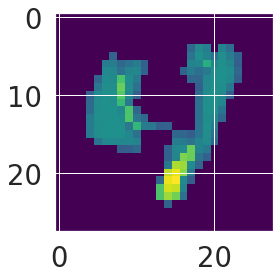

In [47]:
new = imgs[10, :, :] + imgs[11, :, :] 
plt.imshow(new, cmap='viridis')
plt.show()

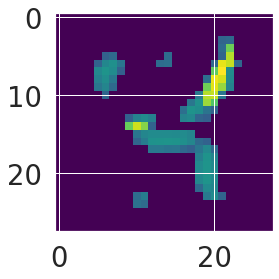

In [48]:
new = imgs[15, :, :] + imgs[16, :, :]
plt.imshow(new, cmap='viridis')
plt.show()

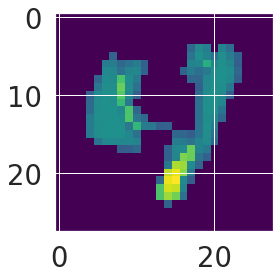

In [49]:
new = imgs[10, :, :] + imgs[11, :, :] 
plt.imshow(new, cmap='viridis')
plt.show()

- 만약 위와 같은 데이터를 이용해 피처를 새로 추가한다면 몇가지 고려해야 할 듯 싶다.

1 피처는 2개 혹은 그 이상 합칠 것인지

2 밸류가 적은 것 + 많은 것 혹은 겹치는 부분을 mean하게 처리할 것인지

3 랜덤으로 여러 데이터를 섞어서 augmentation할 것 인지

피처를 생성한 후 correlation을 확인하는게 필요하다.

## 테스트 데이터를 전처리하여 새로운 피처 확인

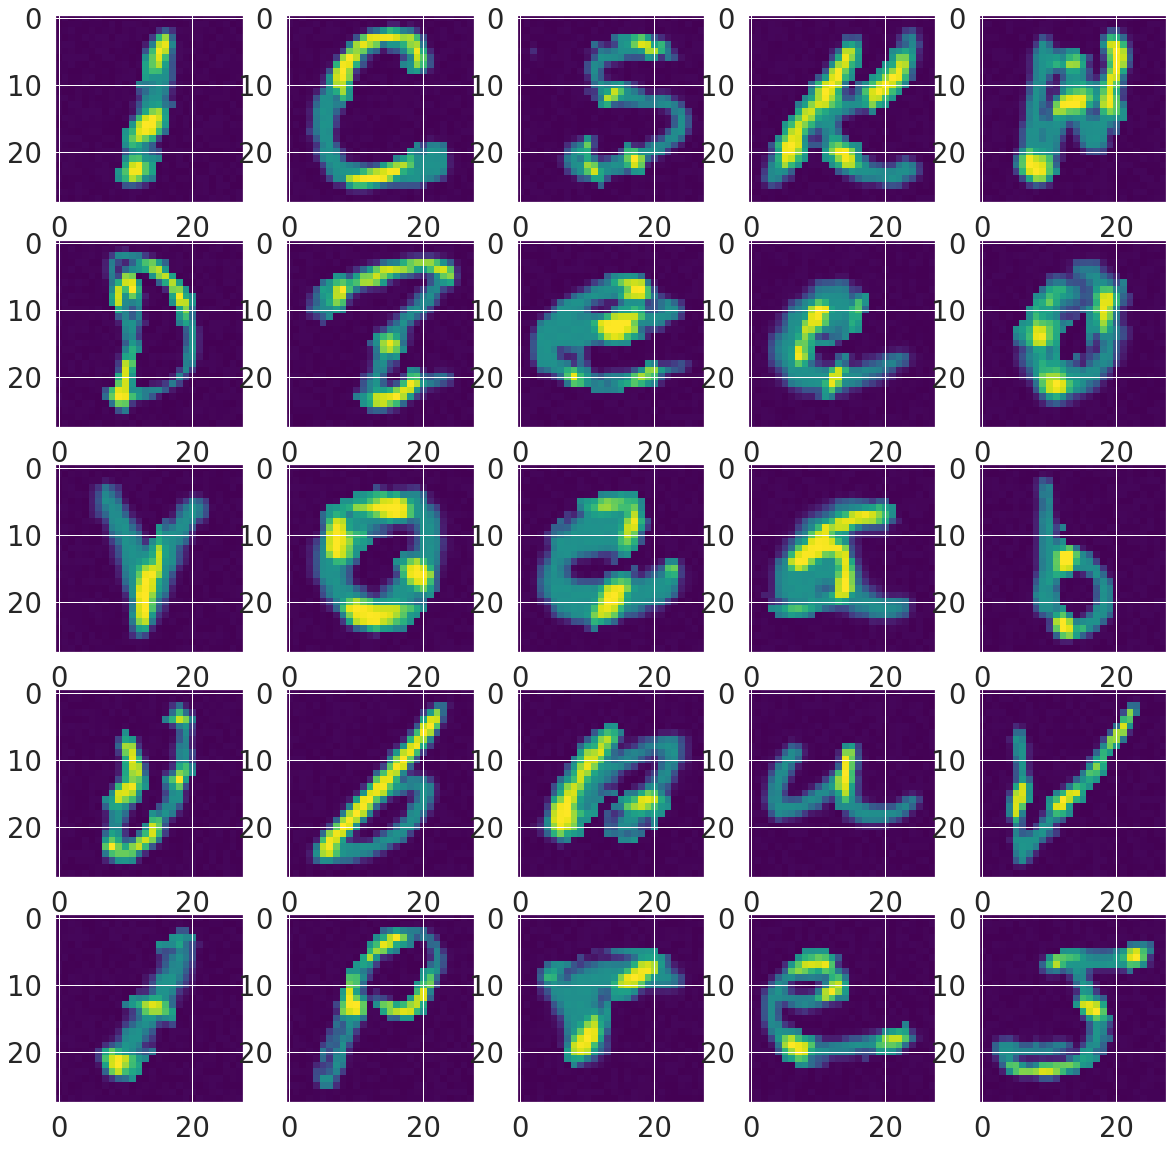

In [30]:
imgs = []

plt.figure(figsize=(20,20))

for i in range(25):
    img = test.iloc[i,2:].values.reshape(28, 28)
    imgs.append(img)

imgs = np.array(imgs)
imgs = imgs.astype(np.float32)

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(imgs[i, :, :], cmap='viridis')

plt.subplot(5,5,25)
plt.show()

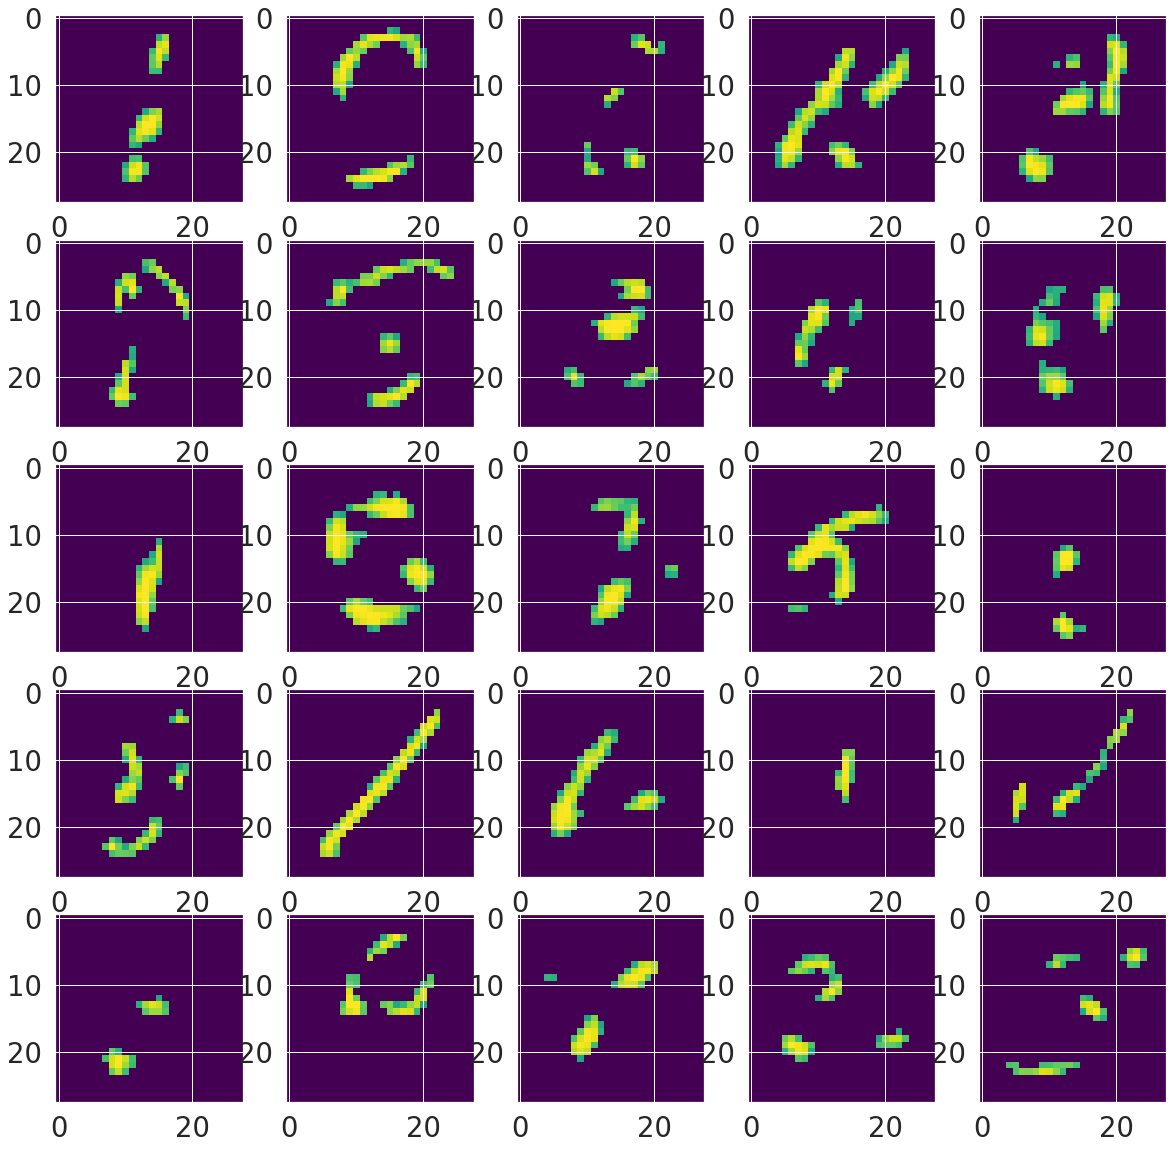

In [32]:
imgs = []

plt.figure(figsize=(20,20))

for i in range(25):
    img = test.iloc[i,2:].values.reshape(28, 28)
    s_img = np.where(img >= 150, img, 0)
    imgs.append(s_img)

# list 자료형으로는 img를 나타낼 수 없으므로 numpy 자료형으로 바꾸어 준다.    
# 데이터 타입 에러 발생으로 np.float32를 추가해준다
imgs = np.array(imgs)
imgs = imgs.astype(np.float32)

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(imgs[i, :, :], cmap='viridis')

plt.subplot(5,5,25)
plt.show()

- 테스트 데이터에도 노이즈 4인 value에 대해 똑같은 전처리가 필요하다.

In [20]:
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
train = pd.read_csv('./datasets/train.csv')

In [22]:
img = train.query("letter == 'A'")[[(str(i)) for i in range(784)]].iloc[28].values.reshape(28, 28)
img = (np.array(img)).astype(np.float32)

<function matplotlib.pyplot.show(*args, **kw)>

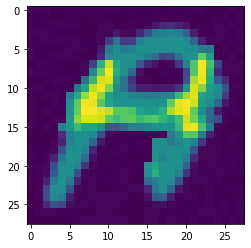

In [41]:
plt.imshow(img)
plt.show


In [42]:
ToPIL = transforms.ToPILImage()
img2 = ToPIL(img)

In [43]:
R_r = transforms.RandomRotation(30)
img3 = R_r(img2)

<function matplotlib.pyplot.show(*args, **kw)>

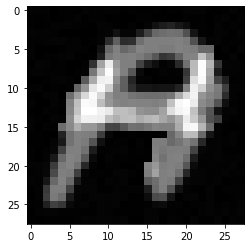

In [44]:
plt.imshow(img3)
plt.show


In [56]:
img4 = np.array(img3)

In [58]:
img4.shape

(28, 28)

In [5]:
import numpy as np
import random

In [6]:
np.random.seed(7)
random.seed(7)
random_state=7

In [7]:
random_state

7

In [5]:
digit_5 = train.query("digit == '5'")
digit_5.head(10)

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
20,21,5,V,3,1,0,4,0,3,1,...,0,0,4,2,2,4,0,1,0,2
27,28,5,P,1,3,1,2,0,1,3,...,3,0,2,4,0,2,3,0,3,4
34,35,5,T,1,4,3,4,2,4,0,...,0,0,2,4,4,3,4,1,3,0
40,41,5,Q,1,1,1,3,2,4,3,...,2,3,1,3,3,3,4,0,4,2
44,45,5,A,2,0,4,2,3,1,3,...,3,1,2,0,4,2,3,4,1,1
52,53,5,G,2,4,0,4,1,1,3,...,3,3,3,1,1,1,1,4,1,3
53,54,5,T,0,4,4,1,2,0,0,...,2,3,2,1,0,1,1,1,4,3
65,66,5,Q,0,3,1,0,3,4,1,...,3,2,3,3,4,3,1,3,2,3
76,77,5,U,1,2,1,2,1,2,1,...,4,2,1,4,4,2,4,1,1,3


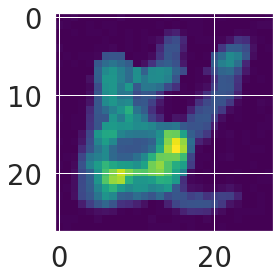

In [15]:
new = imgs[10, :, :] + imgs[11, :, :]
plt.imshow(new, cmap='viridis')
plt.show()

# K means segmentation

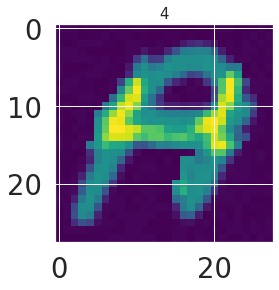

In [33]:
# 영어글자 A, 숫자 4라는 데이터를 이용해 데이터 증각을 해보자

img = train.query("letter == 'A'")[[(str(i)) for i in range(784)]].iloc[28].values.reshape(28, 28)
plt.imshow(img, cmap='viridis')
plt.title(train.query("letter == 'A'").iloc[28]['digit'], fontsize=15)
plt.show()

In [34]:


Z = img.reshape((-1,1))
Z= np.float32(Z)

#입력 데이터를 단일 열(column) 벡터로 구성했다는 것을 기억해야 합니다. 각 특징은 열로 정렬되어 잇어야 합니다
#Z

In [35]:
# define criteria, number of clusters(K) and apply kmeans()

# 뭐지 ?? 시발 float32(Z) 하니까 에러가 안뜬다
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

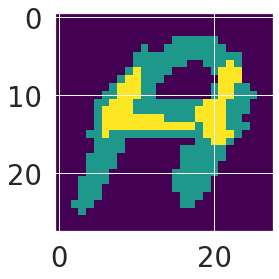

In [36]:
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape(28,28)
plt.imshow(res2, cmap='viridis')
plt.show()

In [37]:
res2

array([[  5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
          5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
          5,   5],
       [  5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
          5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
          5,   5],
       [  5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
          5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
          5,   5],
       [  5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
          5,   5, 116, 116, 116, 116, 116, 116,   5,   5,   5,   5,   5,
          5,   5],
       [  5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5, 116,   5,
          5, 116, 116, 116, 116, 116, 116, 116, 116,   5,   5,   5,   5,
          5,   5],
       [  5,   5,   5,   5,   5,   5,   5,   5,   5,   5, 116, 116, 116,
        116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116,   5,   5,
          5,   5],
       [  

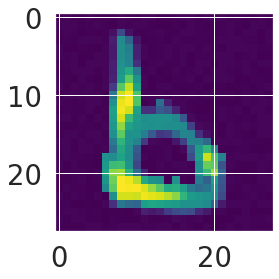

In [10]:
img = train.query("letter == 'B'")[[(str(i)) for i in range(784)]].iloc[0].values.reshape(28, 28)
#new_img = np.where(img < 5, 0, img)# 4이하의 노이즈 삭제


plt.imshow(img, cmap='viridis')
plt.show()

In [11]:
Z = img.reshape((-1,1))
Z= np.float32(Z)

#입력 데이터를 단일 열(column) 벡터로 구성했다는 것을 기억해야 합니다. 각 특징은 열로 정렬되어 잇어야 합니다

In [12]:
# define criteria, number of clusters(K) and apply kmeans()

# 뭐지 ?? 시발 float32(Z) 하니까 에러가 안뜬다
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

In [13]:
a=np.array(center).max()
a

219.02223

In [14]:
ret

152463.69313605386

In [15]:
label

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [16]:
center

array([[219.02223],
       [  3.9392 ],
       [119.86842]], dtype=float32)

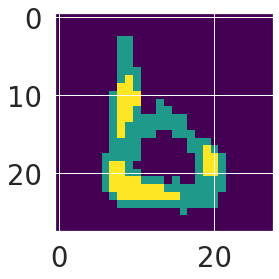

In [17]:
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape(28,28)
plt.imshow(res2, cmap='viridis')
plt.show()

In [18]:
res2

# 아래 값들은 실제 값이 아니라 전체 분류된 값들을 평균을 취한듯 그래서 실제 값을 확인해보면 서로다르다

array([[  3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3],
       [  3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3],
       [  3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3],
       [  3,   3,   3,   3,   3,   3,   3,   3, 119, 119,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3],
       [  3,   3,   3,   3,   3,   3,   3,   3, 119, 119,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3],
       [  3,   3,   3,   3,   3,   3,   3,   3, 119, 119,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3],
       [  

In [19]:
A = Z[label.ravel()==0]
B = Z[label.ravel()==1]
C = Z[label.ravel()==2]

In [20]:
A

array([[192.],
       [189.],
       [234.],
       [236.],
       [253.],
       [183.],
       [248.],
       [255.],
       [186.],
       [251.],
       [238.],
       [239.],
       [174.],
       [213.],
       [192.],
       [170.],
       [235.],
       [184.],
       [175.],
       [177.],
       [197.],
       [192.],
       [212.],
       [218.],
       [174.],
       [220.],
       [199.],
       [255.],
       [249.],
       [227.],
       [192.],
       [255.],
       [253.],
       [254.],
       [242.],
       [216.],
       [190.],
       [238.],
       [239.],
       [236.],
       [250.],
       [245.],
       [240.],
       [228.],
       [211.]], dtype=float32)

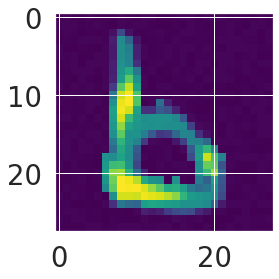

In [21]:
Z= Z.reshape(28,28)
plt.imshow(Z, cmap='viridis')
plt.show()

In [22]:
Z

array([[  0.,   4.,   0.,   0.,   4.,   1.,   1.,   1.,   4.,   2.,   0.,
          3.,   4.,   0.,   0.,   2.,   3.,   4.,   0.,   3.,   4.,   3.,
          0.,   2.,   2.,   1.,   4.,   2.],
       [  3.,   3.,   4.,   1.,   2.,   4.,   2.,   0.,   3.,   2.,   3.,
          3.,   1.,   0.,   0.,   2.,   0.,   4.,   2.,   1.,   2.,   2.,
          4.,   2.,   0.,   3.,   4.,   2.],
       [  1.,   4.,   2.,   0.,   2.,   1.,   2.,  11.,  56.,  11.,   2.,
          1.,   2.,   4.,   1.,   1.,   3.,   4.,   2.,   2.,   0.,   2.,
          4.,   0.,   3.,   4.,   0.,   4.],
       [  0.,   2.,   1.,   4.,   4.,   4.,   2.,  21., 123.,  81.,  14.,
          0.,   1.,   2.,   0.,   3.,   2.,   1.,   2.,   1.,   2.,   4.,
          3.,   4.,   2.,   2.,   0.,   4.],
       [  4.,   0.,   0.,   2.,   1.,   0.,   3.,  18., 126., 108.,  22.,
          4.,   0.,   2.,   4.,   2.,   3.,   3.,   1.,   3.,   2.,   1.,
          3.,   3.,   4.,   4.,   2.,   2.],
       [  3.,   2.,   4.,   0.,   1

In [23]:
a = label
a = np.where(a==2, 0, 1)
b=a.reshape(28, 28)

b

# plt.imshow(b, cmap='viridis')
# plt.show()

# b = np.transpose(b)
# b

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 

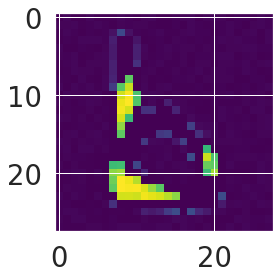

In [24]:
c = b*Z
d=c.reshape(28,28)
plt.imshow(d, cmap='viridis')
plt.show()

In [25]:
d

array([[  0.,   4.,   0.,   0.,   4.,   1.,   1.,   1.,   4.,   2.,   0.,
          3.,   4.,   0.,   0.,   2.,   3.,   4.,   0.,   3.,   4.,   3.,
          0.,   2.,   2.,   1.,   4.,   2.],
       [  3.,   3.,   4.,   1.,   2.,   4.,   2.,   0.,   3.,   2.,   3.,
          3.,   1.,   0.,   0.,   2.,   0.,   4.,   2.,   1.,   2.,   2.,
          4.,   2.,   0.,   3.,   4.,   2.],
       [  1.,   4.,   2.,   0.,   2.,   1.,   2.,  11.,  56.,  11.,   2.,
          1.,   2.,   4.,   1.,   1.,   3.,   4.,   2.,   2.,   0.,   2.,
          4.,   0.,   3.,   4.,   0.,   4.],
       [  0.,   2.,   1.,   4.,   4.,   4.,   2.,  21.,   0.,   0.,  14.,
          0.,   1.,   2.,   0.,   3.,   2.,   1.,   2.,   1.,   2.,   4.,
          3.,   4.,   2.,   2.,   0.,   4.],
       [  4.,   0.,   0.,   2.,   1.,   0.,   3.,  18.,   0.,   0.,  22.,
          4.,   0.,   2.,   4.,   2.,   3.,   3.,   1.,   3.,   2.,   1.,
          3.,   3.,   4.,   4.,   2.,   2.],
       [  3.,   2.,   4.,   0.,   1

In [26]:
e = label
f = np.where(label==2, 177, 0)
g=f.reshape(28, 28)
g

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 177, 177,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 177, 177,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 177, 177,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

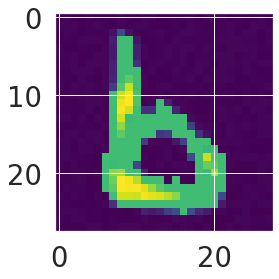

In [27]:
h = d+g
h=h.reshape(28,28)
plt.imshow(h, cmap='viridis')
plt.show()

In [28]:
h

array([[  0.,   4.,   0.,   0.,   4.,   1.,   1.,   1.,   4.,   2.,   0.,
          3.,   4.,   0.,   0.,   2.,   3.,   4.,   0.,   3.,   4.,   3.,
          0.,   2.,   2.,   1.,   4.,   2.],
       [  3.,   3.,   4.,   1.,   2.,   4.,   2.,   0.,   3.,   2.,   3.,
          3.,   1.,   0.,   0.,   2.,   0.,   4.,   2.,   1.,   2.,   2.,
          4.,   2.,   0.,   3.,   4.,   2.],
       [  1.,   4.,   2.,   0.,   2.,   1.,   2.,  11.,  56.,  11.,   2.,
          1.,   2.,   4.,   1.,   1.,   3.,   4.,   2.,   2.,   0.,   2.,
          4.,   0.,   3.,   4.,   0.,   4.],
       [  0.,   2.,   1.,   4.,   4.,   4.,   2.,  21., 177., 177.,  14.,
          0.,   1.,   2.,   0.,   3.,   2.,   1.,   2.,   1.,   2.,   4.,
          3.,   4.,   2.,   2.,   0.,   4.],
       [  4.,   0.,   0.,   2.,   1.,   0.,   3.,  18., 177., 177.,  22.,
          4.,   0.,   2.,   4.,   2.,   3.,   3.,   1.,   3.,   2.,   1.,
          3.,   3.,   4.,   4.,   2.,   2.],
       [  3.,   2.,   4.,   0.,   1